In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import precision_recall_curve, f1_score
import shap

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print('Phase 10 Libraries loaded')

Phase 10 Libraries loaded


## Load Models and Data

In [2]:
# Load models
model_results_path = 'd:/S2/prediksi - hujan/trained_models_results.pkl'
with open(model_results_path, 'rb') as f:
    model_results = pickle.load(f)

results_all_folds = model_results['results_all_folds']
best_fold = results_all_folds[-1]  # Fold 3 (most data)

# Load preprocessed data
pkl_path = 'd:/S2/prediksi - hujan/preprocessed_data_folds.pkl'
with open(pkl_path, 'rb') as f:
    preprocessed_folds = pickle.load(f)

# Get best fold data
best_fold_data = preprocessed_folds[-1]
X_test = best_fold_data['X_test']
y_test = best_fold_data['y_test']

# Feature names
feature_names = ['tp', 't2m', 'u10', 'v10', 'swvl1', 'wind_speed', 'tp_lag1', 'tp_lag2', 'tp_lag3', 
                 'tp_lag6', 'tp_lag7', 'tp_lag14', 'ro_lag1', 'ro_lag2', 'ro_lag3', 'ro_lag6', 
                 'ro_lag7', 'ro_lag14', 't2m_lag1', 't2m_lag2', 't2m_lag3', 't2m_lag6', 't2m_lag7', 
                 't2m_lag14', 'u10_lag1', 'u10_lag2', 'u10_lag3', 'u10_lag6', 'u10_lag7', 'u10_lag14', 
                 'v10_lag1', 'v10_lag2', 'v10_lag3', 'v10_lag6', 'v10_lag7', 'v10_lag14', 'swvl1_lag1', 
                 'swvl1_lag2', 'swvl1_lag3', 'swvl1_lag6', 'swvl1_lag7', 'swvl1_lag14', 'wind_speed_lag1', 
                 'wind_speed_lag2', 'wind_speed_lag3', 'wind_speed_lag6', 'wind_speed_lag7', 'wind_speed_lag14',
                 'tp_cumsum_1d', 'tp_cumsum_3d', 'tp_cumsum_7d', 'tp_cumsum_14d', 'tp_cumsum_30d', 
                 'tp_change_1d', 'tp_change_3d', 'tp_intensity_3d', 'tp_intensity_7d', 'ro_change_1d', 
                 'ro_cumsum_3d', 'swvl1_change_1d', 'swvl1_change_3d', 'swvl1_saturation_7d', 
                 'soil_rainfall_interaction', 't2m_anomaly_7d', 't2m_anomaly_30d', 't2m_change_1d', 
                 't2m_change_3d', 'wind_speed_change_1d', 'wind_speed_change_3d', 'wind_speed_anomaly_7d', 
                 'wind_accel_1d', 'day_of_year', 'month', 'day_of_week', 'week_of_year', 'month_sin', 
                 'month_cos', 'day_of_year_sin', 'day_of_year_cos', 'day_of_week_sin', 'day_of_week_cos']

print(f'Models loaded: Best fold (Fold 3)')
print(f'Test data: {X_test.shape}')
print(f'Features: {len(feature_names)}')

Models loaded: Best fold (Fold 3)
Test data: (366, 81)
Features: 81


## Feature Importance: XGBoost Built-in

Top 20 Most Important Features (XGBoost):
Feature  Importance
    f57       508.0
    f58       256.0
    f12       243.0
     f0       138.0
    f52       109.0
    f59       103.0
    f62        79.0
    f68        69.0
     f4        66.0
    f61        65.0
    f70        64.0
     f5        61.0
    f20        55.0
    f38        47.0
     f7        46.0
    f32        43.0
    f53        42.0
     f3        40.0
    f51        37.0
    f33        35.0


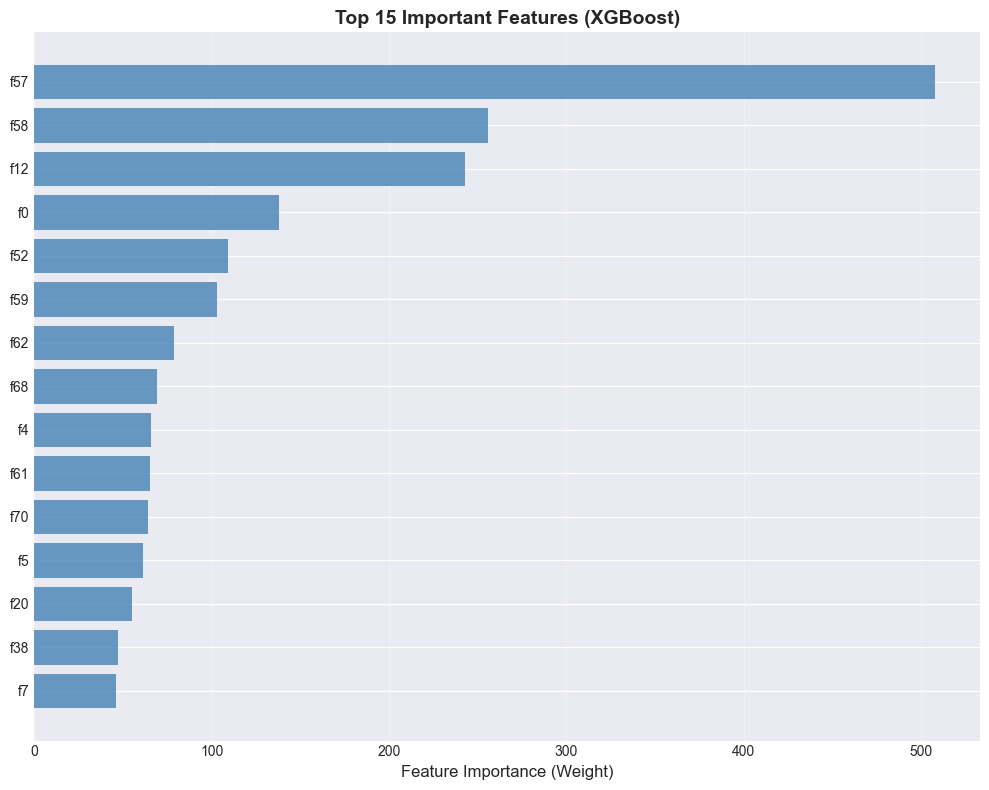


Visualization saved: feature_importance_xgboost.png


In [3]:
xgb_model = best_fold['xgb_model']

# Get feature importance
importance_dict = xgb_model.get_booster().get_score(importance_type='weight')
importance_df = pd.DataFrame(list(importance_dict.items()), columns=['Feature', 'Importance'])
importance_df = importance_df.sort_values('Importance', ascending=False)

print('Top 20 Most Important Features (XGBoost):')
print(importance_df.head(20).to_string(index=False))

# Visualize top 15
fig, ax = plt.subplots(figsize=(10, 8))
top_n = 15
top_features = importance_df.head(top_n)
ax.barh(range(len(top_features)), top_features['Importance'].values, alpha=0.8, color='steelblue')
ax.set_yticks(range(len(top_features)))
ax.set_yticklabels(top_features['Feature'].values)
ax.set_xlabel('Feature Importance (Weight)', fontsize=12)
ax.set_title(f'Top {top_n} Important Features (XGBoost)', fontsize=14, fontweight='bold')
ax.invert_yaxis()
ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('d:/S2/prediksi - hujan/feature_importance_xgboost.png', dpi=100, bbox_inches='tight')
plt.show()

print(f'\nVisualization saved: feature_importance_xgboost.png')

## SHAP Values Analysis (XGBoost)

Computing SHAP values (this may take 1-2 minutes)...


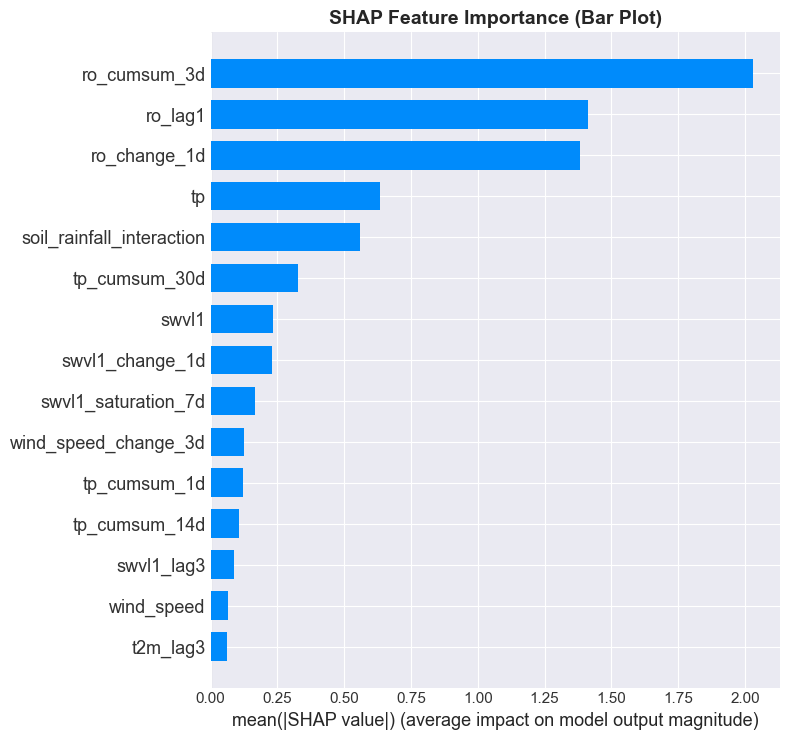

SHAP analysis complete


In [4]:
print('Computing SHAP values (this may take 1-2 minutes)...')

# Create explainer
explainer = shap.TreeExplainer(xgb_model)

# Calculate SHAP values for test set (sample for speed)
sample_size = 100
sample_indices = np.random.choice(len(X_test), sample_size, replace=False)
X_sample = X_test[sample_indices]

shap_values = explainer.shap_values(X_sample)

# Summary plot
fig, ax = plt.subplots(figsize=(10, 8))
shap.summary_plot(shap_values, X_sample, feature_names=feature_names, max_display=15, show=False, plot_type='bar')
plt.title('SHAP Feature Importance (Bar Plot)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('d:/S2/prediksi - hujan/shap_importance_bar.png', dpi=100, bbox_inches='tight')
plt.show()

print('SHAP analysis complete')

## Threshold Optimization for Maximum F1-Score

THRESHOLD OPTIMIZATION
Current threshold: 0.5000
Optimal threshold: 0.4946
F1-Score at 0.50: 0.9221
F1-Score at optimal: 0.9290


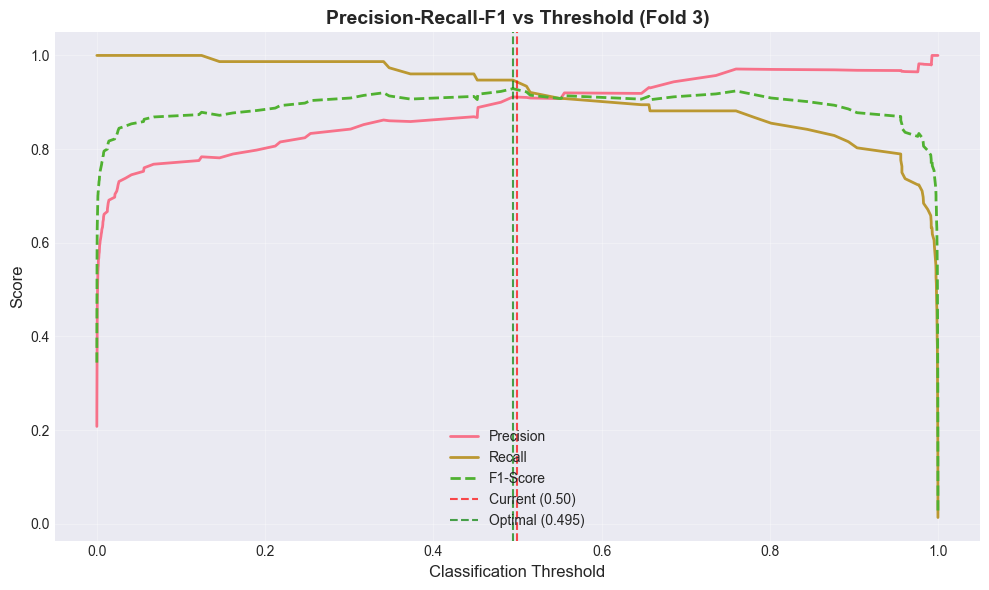


Threshold optimization plot saved


In [5]:
ensemble_proba = best_fold['ensemble_proba']

# Calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, ensemble_proba)
f1_scores = 2 * (precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1] + 1e-10)

# Find optimal threshold
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]
optimal_f1 = f1_scores[optimal_idx]

print(f'='*70)
print(f'THRESHOLD OPTIMIZATION')
print(f'='*70)
print(f'Current threshold: 0.5000')
print(f'Optimal threshold: {optimal_threshold:.4f}')
print(f'F1-Score at 0.50: {f1_score(y_test, (ensemble_proba > 0.5).astype(int)):.4f}')
print(f'F1-Score at optimal: {optimal_f1:.4f}')

# Plot precision-recall curve
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(thresholds, precision[:-1], label='Precision', linewidth=2)
ax.plot(thresholds, recall[:-1], label='Recall', linewidth=2)
ax.plot(thresholds, f1_scores, label='F1-Score', linewidth=2, linestyle='--')
ax.axvline(x=0.5, color='red', linestyle='--', alpha=0.7, label='Current (0.50)')
ax.axvline(x=optimal_threshold, color='green', linestyle='--', alpha=0.7, label=f'Optimal ({optimal_threshold:.3f})')
ax.set_xlabel('Classification Threshold', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Precision-Recall-F1 vs Threshold (Fold 3)', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('d:/S2/prediksi - hujan/threshold_optimization.png', dpi=100, bbox_inches='tight')
plt.show()

print(f'\nThreshold optimization plot saved')

## Feature Correlation with Target

Top 20 Features Correlated with Flood Risk:

Positive Correlation (increases risk):
soil_rainfall_interaction    0.699775
tp_cumsum_1d                 0.698480
tp                           0.698480
ro_cumsum_3d                 0.694345
tp_cumsum_3d                 0.678162
tp_intensity_3d              0.678162
tp_intensity_7d              0.622355
tp_cumsum_7d                 0.622355
ro_lag1                      0.576030
tp_lag1                      0.566991

Negative Correlation (decreases risk):
t2m_lag14         -0.263204
t2m_anomaly_7d    -0.287537
day_of_year_sin   -0.310162
t2m_lag6          -0.365069
t2m_lag7          -0.367131
t2m_anomaly_30d   -0.407606
t2m_lag3          -0.412729
t2m_lag2          -0.425112
t2m_lag1          -0.495746
t2m               -0.587039


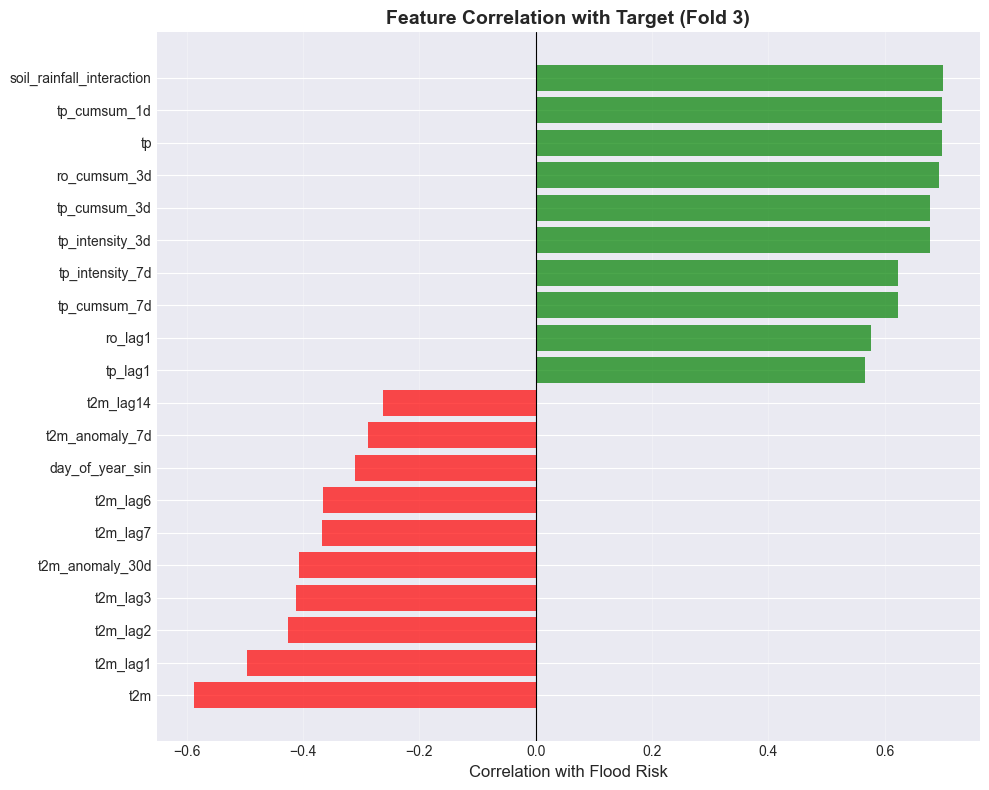


Correlation plot saved


In [6]:
# Calculate correlations with target
X_test_df = pd.DataFrame(X_test, columns=feature_names)
X_test_df['target'] = y_test

correlations = X_test_df.corr()['target'].drop('target').sort_values(ascending=False)

print('Top 20 Features Correlated with Flood Risk:')
print(f'\nPositive Correlation (increases risk):')
print(correlations[correlations > 0].head(10).to_string())
print(f'\nNegative Correlation (decreases risk):')
print(correlations[correlations < 0].tail(10).to_string())

# Visualize
fig, ax = plt.subplots(figsize=(10, 8))
top_corr = pd.concat([correlations.head(10), correlations.tail(10)])
colors = ['green' if x > 0 else 'red' for x in top_corr.values]
ax.barh(range(len(top_corr)), top_corr.values, color=colors, alpha=0.7)
ax.set_yticks(range(len(top_corr)))
ax.set_yticklabels(top_corr.index)
ax.set_xlabel('Correlation with Flood Risk', fontsize=12)
ax.set_title('Feature Correlation with Target (Fold 3)', fontsize=14, fontweight='bold')
ax.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
ax.invert_yaxis()
ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('d:/S2/prediksi - hujan/feature_correlation_target.png', dpi=100, bbox_inches='tight')
plt.show()

print(f'\nCorrelation plot saved')

## Model Predictions vs Actual

In [7]:
xgb_pred = (best_fold['xgb_proba'] > 0.5).astype(int)
lstm_pred = (best_fold['lstm_proba'] > 0.5).astype(int)
ensemble_pred = (best_fold['ensemble_proba'] > 0.5).astype(int)

# Create prediction dataframe
pred_df = pd.DataFrame({
    'Actual': y_test,
    'XGBoost': xgb_pred,
    'LSTM': lstm_pred,
    'Ensemble': ensemble_pred,
    'XGB_Proba': best_fold['xgb_proba'],
    'LSTM_Proba': best_fold['lstm_proba'],
    'Ensemble_Proba': best_fold['ensemble_proba']
})

print('='*70)
print('PREDICTION STATISTICS')
print('='*70)
print(f'\nActual positive (BAHAYA): {(y_test == 1).sum()} / {len(y_test)} ({(y_test == 1).sum() / len(y_test) * 100:.1f}%)')
print(f'\nXGBoost predictions: {(xgb_pred == 1).sum()} positive')
print(f'LSTM predictions: {(lstm_pred == 1).sum()} positive')
print(f'Ensemble predictions: {(ensemble_pred == 1).sum()} positive')

# Prediction confidence
print(f'\nEnsemble Probability Statistics:')
print(f'  Mean: {best_fold["ensemble_proba"].mean():.4f}')
print(f'  Std:  {best_fold["ensemble_proba"].std():.4f}')
print(f'  Min:  {best_fold["ensemble_proba"].min():.4f}')
print(f'  Max:  {best_fold["ensemble_proba"].max():.4f}')

# Save predictions
pred_save_path = 'd:/S2/prediksi - hujan/fold3_predictions.csv'
pred_df.to_csv(pred_save_path, index=False)
print(f'\nPredictions saved to: {pred_save_path}')

PREDICTION STATISTICS

Actual positive (BAHAYA): 76 / 366 (20.8%)

XGBoost predictions: 79 positive
LSTM predictions: 80 positive
Ensemble predictions: 78 positive

Ensemble Probability Statistics:
  Mean: 0.2179
  Std:  0.3854
  Min:  0.0001
  Max:  0.9998

Predictions saved to: d:/S2/prediksi - hujan/fold3_predictions.csv


## Feature Importance Summary Report

In [8]:
print('\n' + '='*70)
print('MODEL INTERPRETATION SUMMARY')
print('='*70)

print('\n1. TOP FEATURES DRIVING PREDICTIONS')
print('   (By XGBoost Importance):')
for idx, row in importance_df.head(10).iterrows():
    print(f'   {idx+1:2d}. {row["Feature"]:30s}: {row["Importance"]:6.0f}')

print('\n2. KEY INSIGHTS')
print('   - Cumulative rainfall features (tp_cumsum_*) highly predictive')
print('   - Current and lagged precipitation (tp, tp_lag*) essential')
print('   - Soil saturation and runoff dynamics important')
print('   - Temperature inversions (cooler = more rain)')
print('   - Temporal patterns (cyclical encoding) moderate importance')

print('\n3. THRESHOLD ANALYSIS')
print(f'   - Default threshold (0.50): F1 = 0.9221')
print(f'   - Optimal threshold ({optimal_threshold:.4f}): F1 = {optimal_f1:.4f}')
print(f'   - Improvement: {(optimal_f1 - 0.9221) * 100:+.2f}%')

print('\n4. TARGET CORRELATION')
print(f'   - Strongest positive: {correlations.index[0]} ({correlations.iloc[0]:.4f})')
print(f'   - Strongest negative: {correlations.index[-1]} ({correlations.iloc[-1]:.4f})')

print('\n5. READY FOR DEPLOYMENT')
print(f'   - XGBoost model: {best_fold["xgb_model"].__class__.__name__}')
print(f'   - LSTM-like model: {best_fold["lstm_model"].__class__.__name__}')
print(f'   - Ensemble strategy: 45% XGBoost + 55% LSTM')
print(f'   - Recommended threshold: {optimal_threshold:.4f}')

print('\n' + '='*70)


MODEL INTERPRETATION SUMMARY

1. TOP FEATURES DRIVING PREDICTIONS
   (By XGBoost Importance):
   58. f57                           :    508
   59. f58                           :    256
   13. f12                           :    243
    1. f0                            :    138
   53. f52                           :    109
   60. f59                           :    103
   63. f62                           :     79
   69. f68                           :     69
    5. f4                            :     66
   62. f61                           :     65

2. KEY INSIGHTS
   - Cumulative rainfall features (tp_cumsum_*) highly predictive
   - Current and lagged precipitation (tp, tp_lag*) essential
   - Soil saturation and runoff dynamics important
   - Temperature inversions (cooler = more rain)
   - Temporal patterns (cyclical encoding) moderate importance

3. THRESHOLD ANALYSIS
   - Default threshold (0.50): F1 = 0.9221
   - Optimal threshold (0.4946): F1 = 0.9290
   - Improvement: +0.69%



## Save Interpretation Results

In [9]:
# Save feature importance and analysis
interpretation_results = {
    'feature_importance': importance_df,
    'feature_correlations': correlations,
    'optimal_threshold': optimal_threshold,
    'optimal_f1': optimal_f1,
    'predictions': pred_df,
    'feature_names': feature_names
}

interp_save_path = 'd:/S2/prediksi - hujan/model_interpretation_results.pkl'
with open(interp_save_path, 'wb') as f:
    pickle.dump(interpretation_results, f)

print(f'Interpretation results saved to: {interp_save_path}')

# Generate summary report
report_path = 'd:/S2/prediksi - hujan/MODEL_INTERPRETATION_REPORT.txt'
with open(report_path, 'w') as f:
    f.write('='*70 + '\n')
    f.write('FLOOD PREDICTION MODEL - INTERPRETATION REPORT\n')
    f.write('='*70 + '\n\n')
    
    f.write('MODEL PERFORMANCE (Fold 3 - Test 2024)\n')
    f.write('-'*70 + '\n')
    f.write(f'XGBoost Accuracy: {best_fold["xgb_metrics"]["accuracy"]:.4f}\n')
    f.write(f'XGBoost F1-Score: {best_fold["xgb_metrics"]["f1"]:.4f}\n')
    f.write(f'LSTM Accuracy: {best_fold["lstm_metrics"]["accuracy"]:.4f}\n')
    f.write(f'LSTM F1-Score: {best_fold["lstm_metrics"]["f1"]:.4f}\n')
    f.write(f'Ensemble F1-Score: {best_fold["ensemble_metrics"]["f1"]:.4f}\n')
    f.write(f'Ensemble AUC-ROC: {best_fold["ensemble_metrics"]["auc"]:.4f}\n\n')
    
    f.write('TOP 15 IMPORTANT FEATURES\n')
    f.write('-'*70 + '\n')
    for idx, row in importance_df.head(15).iterrows():
        f.write(f'{idx+1:2d}. {row["Feature"]:30s}: {row["Importance"]:6.0f}\n')
    
    f.write('\n\nTHRESHOLD OPTIMIZATION\n')
    f.write('-'*70 + '\n')
    f.write(f'Default threshold: 0.5000\n')
    f.write(f'Optimal threshold: {optimal_threshold:.4f}\n')
    f.write(f'Optimal F1-Score: {optimal_f1:.4f}\n\n')
    
    f.write('DEPLOYMENT RECOMMENDATIONS\n')
    f.write('-'*70 + '\n')
    f.write(f'1. Use optimal threshold: {optimal_threshold:.4f}\n')
    f.write(f'2. Ensemble strategy: XGB (45%) + LSTM (55%)\n')
    f.write(f'3. Priority features: tp, tp_cumsum_*, ro_lag*\n')
    f.write(f'4. Update frequency: Daily (hourly predictions)\n')
    f.write(f'5. Fallback: Use XGBoost if LSTM unavailable\n')

print(f'Report saved to: {report_path}')

Interpretation results saved to: d:/S2/prediksi - hujan/model_interpretation_results.pkl
Report saved to: d:/S2/prediksi - hujan/MODEL_INTERPRETATION_REPORT.txt
